# Machine Learning for Predictive Analytics Mini Sprint
This notebook is documents the process of building a predictive model for the Machine Learning for Predictive Analytics Mini Sprint. We worked with a dataset from Bain & Company's HR department. The dataset contains information about employee attrition and our goal is to build a highly accurate model that can predict which employees are likely to leave the company, and to identify the key factors that influence attrition.

In [72]:
# Here we import all our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
from IPython.display import Image
from pandas.api import types 
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier, plot_importance, plot_tree

# Set the path to the data and unzip it
data_path = '../data/predictive-analytics-sprint/'

In [ ]:
zip_file = 'data.zip'
!unzip -o {data_path + zip_file} -d {data_path}

## Cleaning and Preprocessing Data

In [39]:
# Load the data
general_data = pd.read_csv(data_path + 'general_data.csv')
# We swap the columns 'EmployeeID' and 'Age' to make the data more readable
cols = list(general_data.columns)
a, b = cols.index('EmployeeID'), cols.index('Age')
cols[b], cols[a] = cols[a], cols[b]
general_data = general_data[cols]

employee_survey_data = pd.read_csv(data_path + 'employee_survey_data.csv')
manager_survey_data = pd.read_csv(data_path + 'manager_survey_data.csv')

display(general_data.head() , employee_survey_data.head() , manager_survey_data.head())

,EmployeeID,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Age,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,1,No,Travel_Rarely,Sales,6,2,Life Sciences,1,51,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,2,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,31,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,3,No,Travel_Frequently,Research & Development,17,4,Other,1,32,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,4,No,Non-Travel,Research & Development,2,5,Life Sciences,1,38,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,5,No,Travel_Rarely,Research & Development,10,1,Medical,1,32,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [40]:
# Here we merge all three data frames into oneon the employee column
data = pd.merge(general_data, employee_survey_data, on='EmployeeID')
data = pd.merge(data, manager_survey_data, on='EmployeeID')
display(data.head())

,EmployeeID,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Age,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,1,No,Travel_Rarely,Sales,6,2,Life Sciences,1,51,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,2,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,31,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,3,No,Travel_Frequently,Research & Development,17,4,Other,1,32,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,4,No,Non-Travel,Research & Development,2,5,Life Sciences,1,38,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,5,No,Travel_Rarely,Research & Development,10,1,Medical,1,32,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [ ]:
# We can save the data to a csv file  for later use
data.to_csv(data_path + 'employee_data.csv', index=False)

In [41]:
# Loop through the columns and convert the non-numeric columns to numeric
for column in data.columns:
  # Check if the data type is not an integer or a float
  if not types.is_numeric_dtype(data[column]):
    # One hot encode the column with numerical categories
    data[column] = pd.Categorical(data[column])
    data[column] = data[column].cat.codes
data.head()

,EmployeeID,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Age,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,1,0,2,2,6,2,1,1,51,0,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,2,1,1,1,10,1,1,1,31,0,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,3,0,1,1,17,4,4,1,32,1,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,4,0,0,1,2,5,1,1,38,1,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,5,0,2,1,10,1,3,1,32,1,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [42]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Select the columns to normalize (excluding 'Attrition')
columns_to_normalize = data.columns[data.columns != 'Attrition']
# Normalize the selected columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
data.head()

,EmployeeID,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Age,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,0.000000,0,1.0,1.0,0.178571,0.25,0.2,0.0,0.785714,0.0,...,0.025,1.000000,0.025,0.000000,0.000000,0.666667,1.000000,0.333333,0.666667,0.0
1,0.000227,1,0.5,0.5,0.321429,0.00,0.2,0.0,0.309524,0.0,...,0.150,0.500000,0.125,0.066667,0.235294,0.666667,0.333333,1.000000,0.333333,1.0
2,0.000454,0,0.5,0.5,0.571429,0.75,0.8,0.0,0.333333,1.0,...,0.125,0.333333,0.125,0.000000,0.176471,0.333333,0.333333,0.000000,0.666667,0.0
3,0.000680,0,0.0,0.5,0.035714,1.00,0.2,0.0,0.476190,1.0,...,0.325,0.833333,0.200,0.466667,0.294118,1.000000,1.000000,0.666667,0.333333,0.0
4,0.000907,0,1.0,0.5,0.321429,0.00,0.6,0.0,0.333333,1.0,...,0.225,0.333333,0.150,0.000000,0.235294,1.000000,0.000000,0.666667,0.666667,0.0


## Data Analysis 

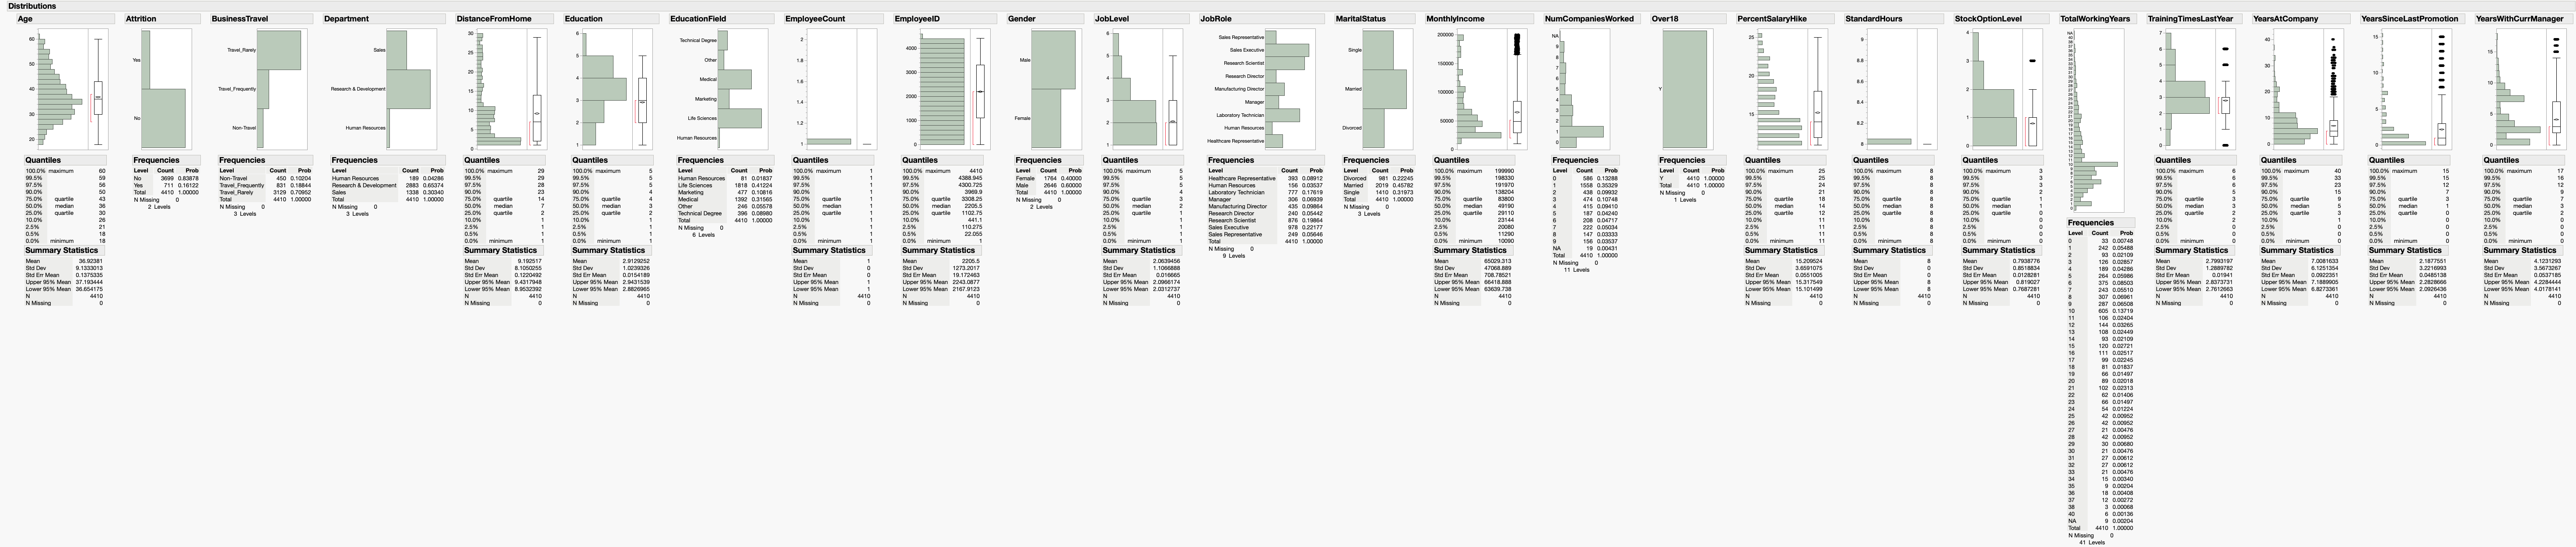

In [43]:
data_description = 'data_description.png'
display(Image(data_path + data_description))

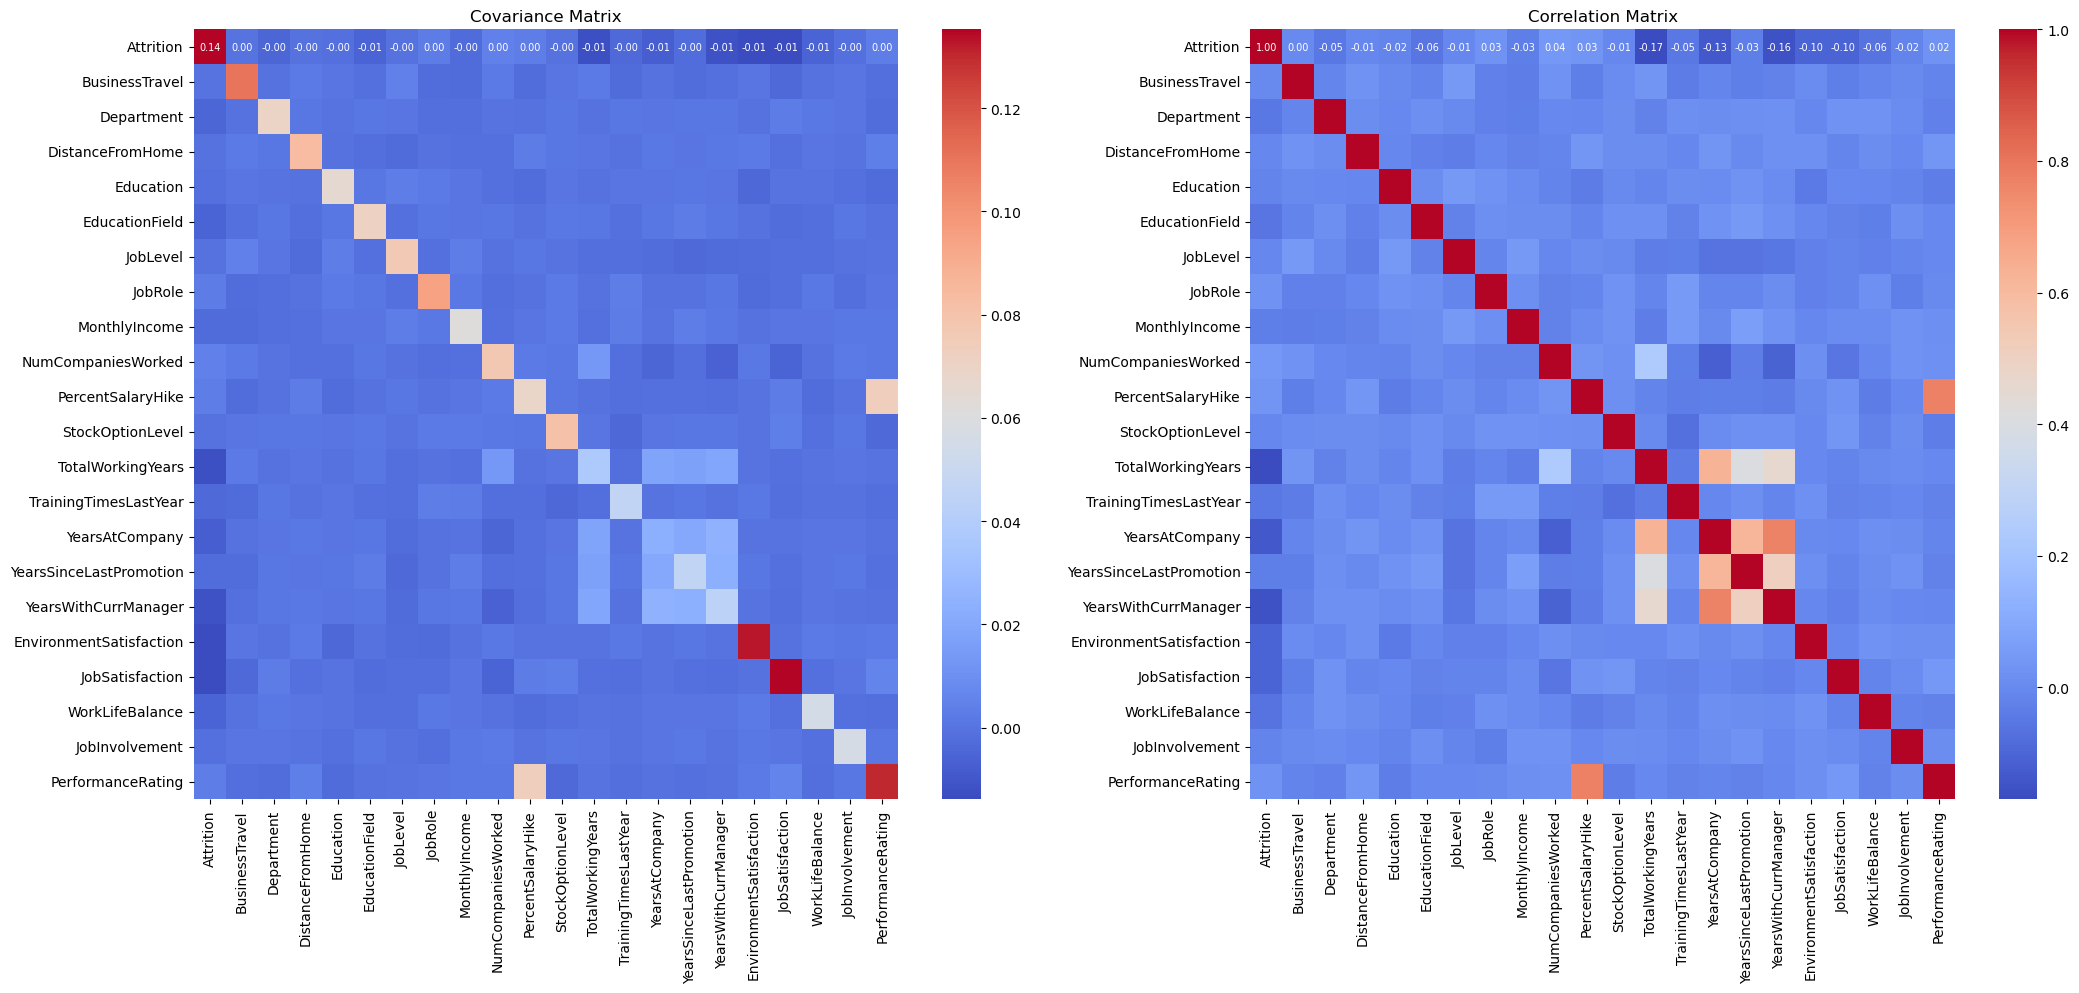

In [76]:
cov_matrix = data.cov()
corr_matrix = data.corr()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10)) 

# Plot covariance matrix
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', ax=ax1, fmt='.2f', annot_kws={'size': 7})
ax1.set_title('Covariance Matrix')

# Plot correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax2, fmt='.2f', annot_kws={'size': 7})
ax2.set_title('Correlation Matrix')

plt.show()

In [45]:
drop_columns = ['EmployeeID', 'EmployeeCount', 'Over18', 'StandardHours', 'MaritalStatus', 'Age', 'Over18', 'Gender']
data = data.drop(columns=drop_columns)

## Model Setup
### Decision Tree Models vs. Logistic Regression
Based on our analysis, we will set up a model to predict employee attrition. We needed to decide between a logistic regression model or decision trees. After doing some research, we decided to use decision trees because they are more interpretable and can help us identify the key factors that influence attrition. We decided to build two models: One being a decision tree and the other being a gradient boosted forest. The reasoning for this is we believe while the gradient boosted forest will be more accurate, the decision tree will be more interpretable and will help us identify the key factors that influence attrition. This will benefit us in terms of explainability When presenting our findings to the HR lead, Kim.

In [46]:
# Split the data into training,testing and validation sets
x_data = data.drop('Attrition', axis=1)
y_data = data['Attrition']
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
#test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size=0.5, random_state=42)
display(train_x.shape, test_x.shape)

(3528, 21)

(882, 21)

In [47]:
estimators = 1
max_depth = 10
learning_rate = 1
decision_tree_model = XGBClassifier(n_estimators=estimators, max_depth=max_depth, learning_rate=learning_rate, objective='binary:logistic')

In [48]:
estimators = 500
max_depth = 4
learning_rate = 0.3
xgb_model = XGBClassifier(n_estimators=estimators, max_depth=max_depth, learning_rate=learning_rate, objective='binary:logistic')

## Training and Evaluation
### Understanding Model Execution
We will train the models on the training data and evaluate their performance on the test data. We will use the following metrics to evaluate the models: accuracy, precision, recall, and F1 score. We will also use a confusion matrix to visualize the performance of the models.
We need to consider the following parameters For decision trees:
- max_depth: The maximum depth of the tree. Increasing the maximum depth of the tree will increase the complexity of the model and may lead to overfitting. 
- learning_rate: The learning rate of the gradient boosted forest. A lower learning rate will similarly make the model more susceptible to overfitting and will require more trees, but can Potentially achieve higher levels of accuracy. 
- n_estimators: The number of trees in the gradient boosted forest. Increasing the number of trees seems to have the most effect on training time, but overall the training still finishes in a matter of seconds with even 500 estimators.

With all three of these parameters we will be sure to cross validate With our test set to ensure we are not overfitting. All of these seem to have a negligible effect on training time, with the number of estimators having the most effect, but even with 500 estimators the training still finishes in a matter of seconds.

In [49]:
decision_tree_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [50]:
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [51]:
decision_tree_model_score = decision_tree_model.score(test_x, test_y)
xgb_model_score = xgb_model.score(test_x, test_y)
print(f'Decision Tree Model Score: {decision_tree_model_score}')
print(f'GBoost Model Score: {xgb_model_score}')

Decision Tree Model Score: 0.8900226757369615
GBoost Model Score: 0.9931972789115646


[[1.         0.        ]
 [0.04255319 0.95744681]]


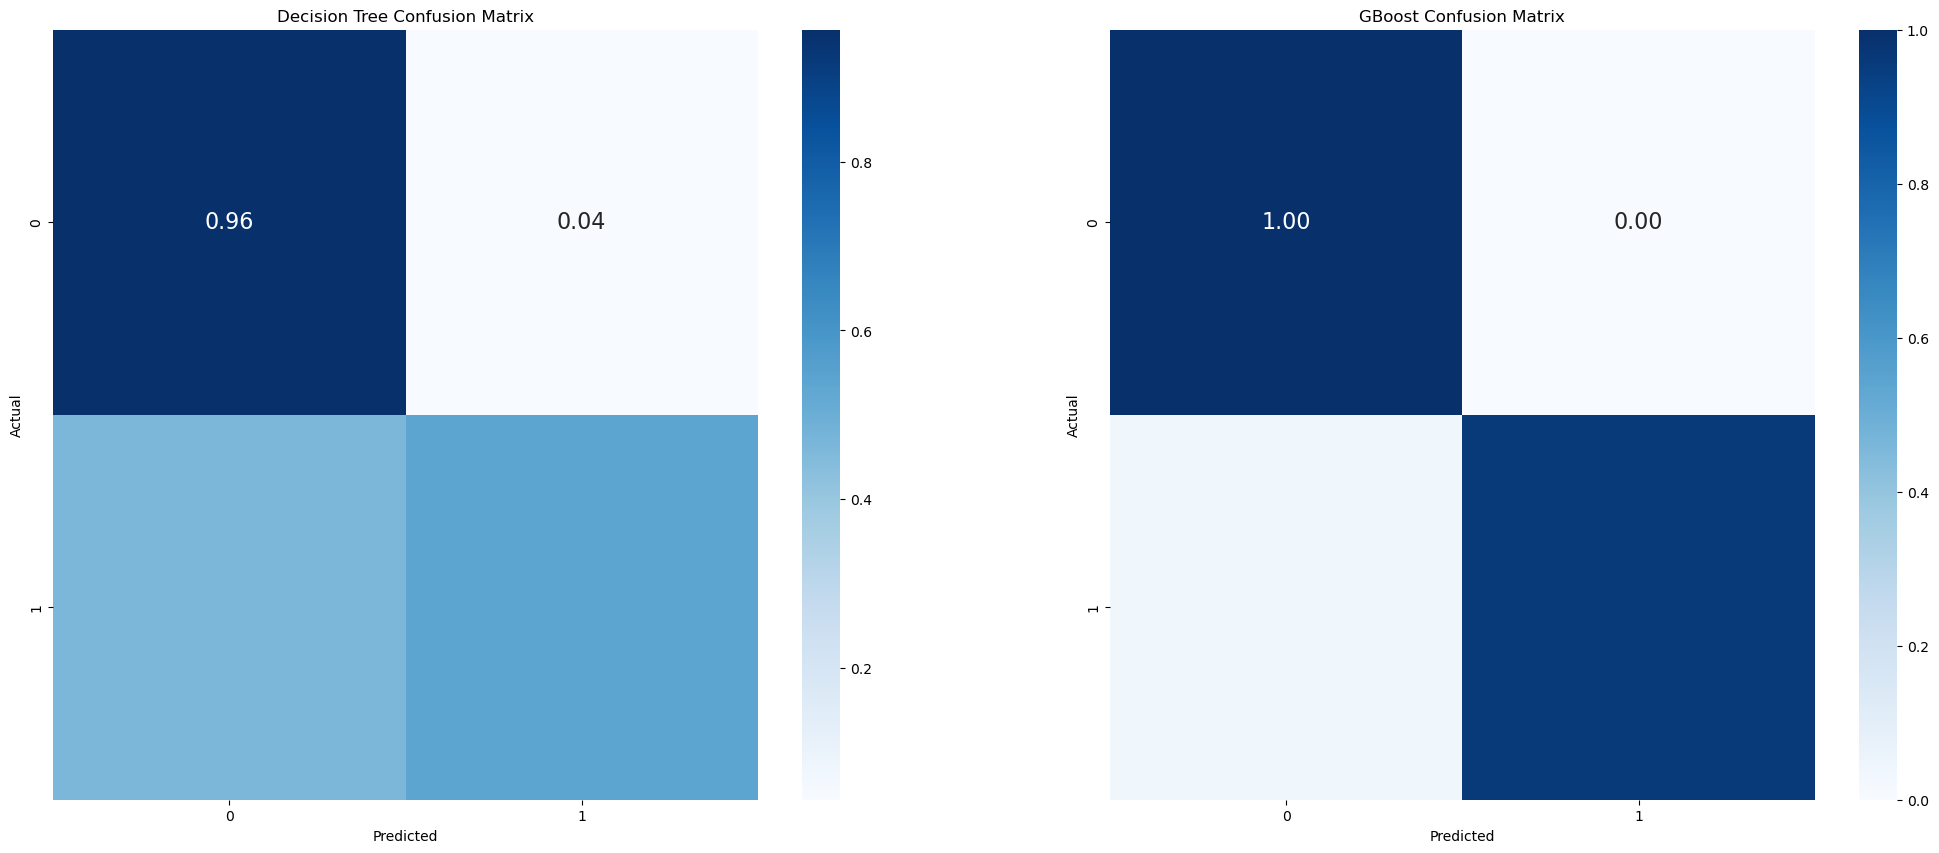

In [75]:
# Make predictions using the decision tree model
decision_tree_predictions = decision_tree_model.predict(test_x)
decision_tree_cm = confusion_matrix(test_y, decision_tree_predictions)
decision_tree_cm = normalize(decision_tree_cm, axis=1, norm='l1')

# Make predictions using the XGBoost model
gboost_predictions = xgb_model.predict(test_x)
gboost_cm = confusion_matrix(test_y, gboost_predictions)
gboost_cm = normalize(gboost_cm, axis=1, norm='l1')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Confusion matrix for Decision Tree
sns.heatmap(decision_tree_cm, annot=True, cmap='Blues', ax=ax1,  fmt='.2f', annot_kws={"size": 16, ""})
ax1.set_title('Decision Tree Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Confusion matrix for Gradient Boosting
sns.heatmap(gboost_cm, annot=True, cmap='Blues', ax=ax2,  fmt='.2f', annot_kws={"size": 16})
ax2.set_title('GBoost Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

print(gboost_cm)


## Visualizations and Insights

<Axes: >

<Figure size 2500x1500 with 0 Axes>

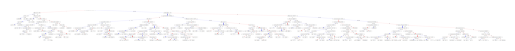

In [33]:
plt.figure(figsize=(25, 15))
plot_tree(decision_tree_model, num_trees=0)

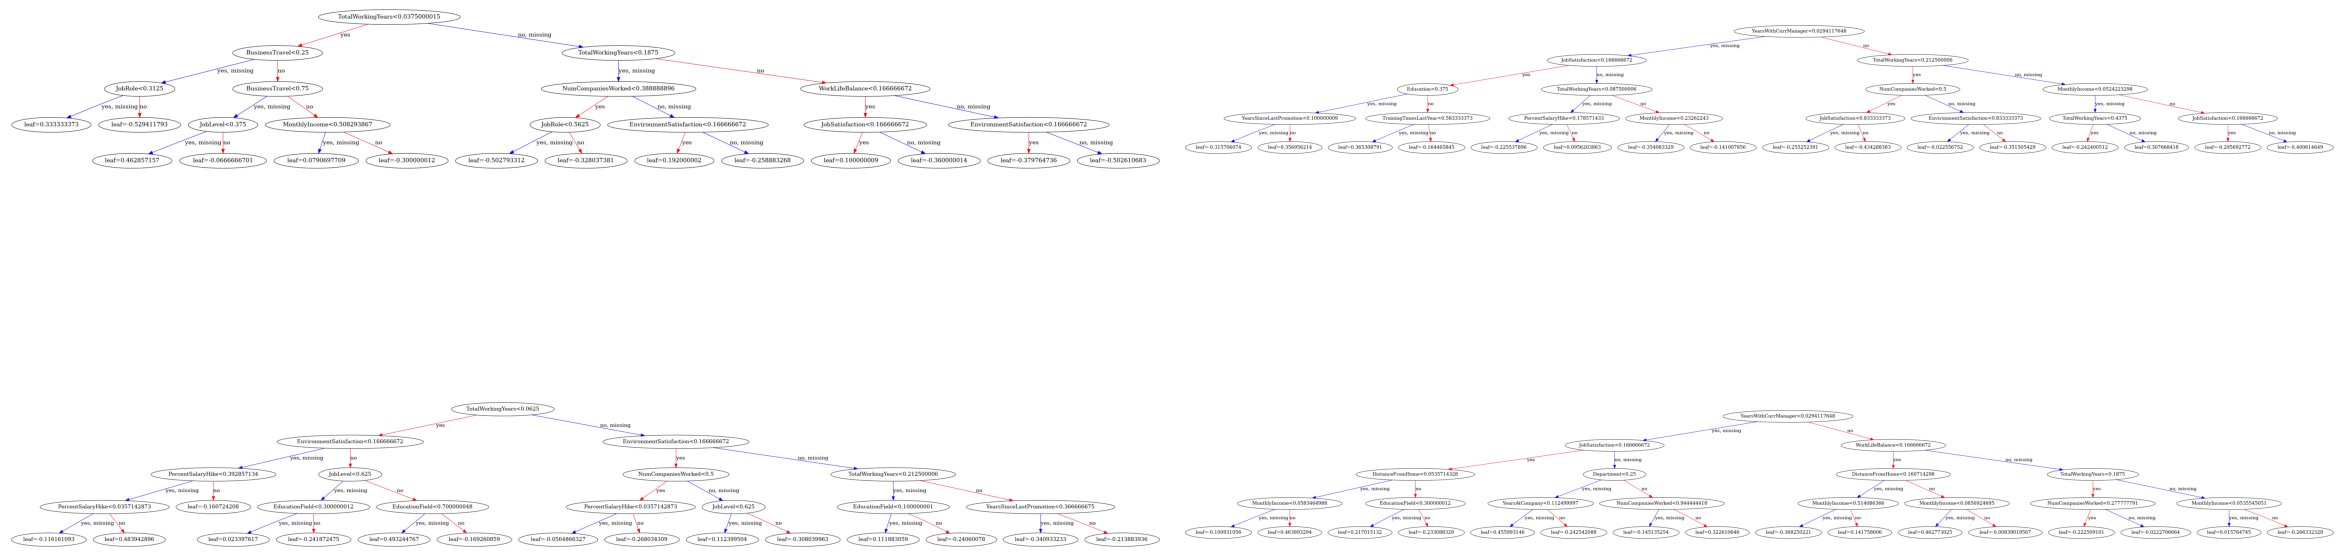

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))
for i in range(4):
    plot_tree(xgb_model, num_trees=i, ax=axes[i//2, i%2])
plt.subplots_adjust(wspace=0.02, hspace=0.0002)

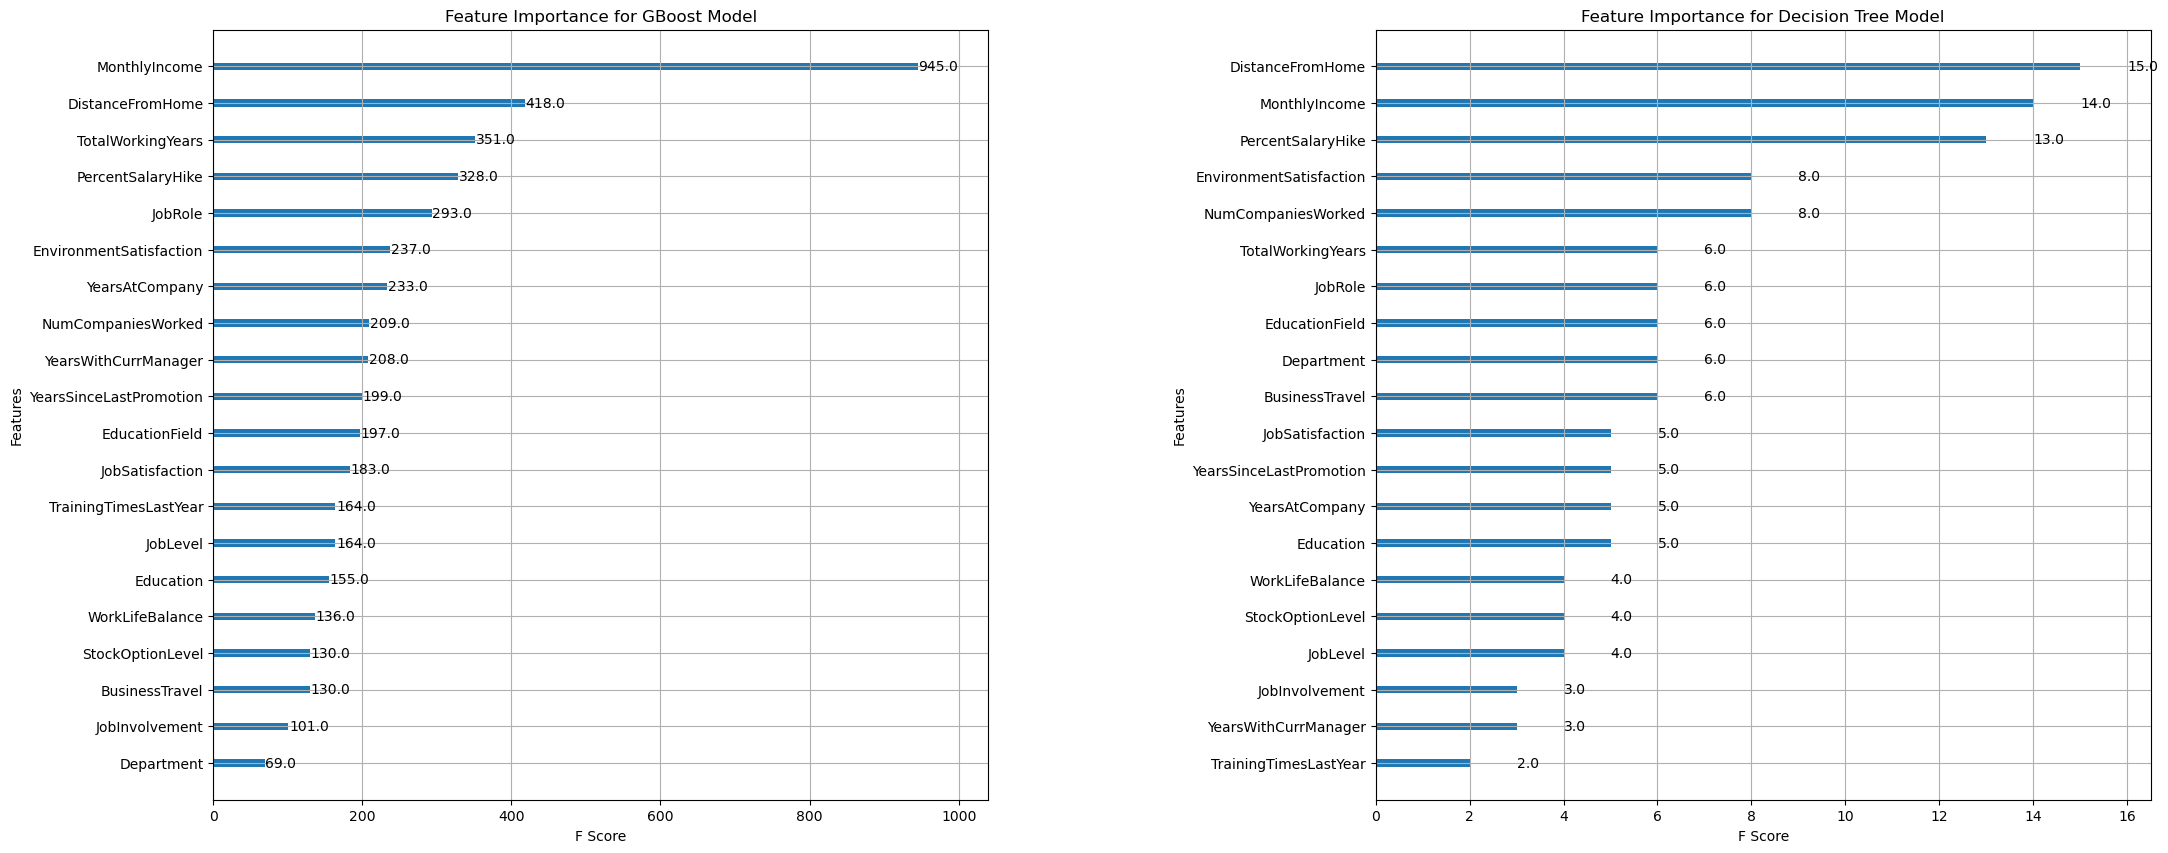

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
plot_importance(xgb_model, ax=ax1)
ax1.set_title('Feature Importance for GBoost Model')
ax1.set_xlabel('F Score')
ax1.set_ylabel('Features')

plot_importance(decision_tree_model, ax=ax2)
ax2.set_title('Feature Importance for Decision Tree Model')
ax2.set_xlabel('F Score')
ax2.set_ylabel('Features')

plt.subplots_adjust(wspace=0.5)